### Syllabification Notebook
- This notebook takes WAV datasets generated by `Create Birdsong WAV Dataset.ipynb` and syllabifies the wavs
- TODO
  - parallelization

### Import Packages

In [1]:
# iPython specific stuff
%matplotlib inline
import IPython.display
from ipywidgets import interact, interactive, fixed

# Packages we're using
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import scipy.ndimage
from glob import glob
from tqdm import tqdm
from datetime import datetime, timedelta
import itertools
import h5py
from scipy import stats
from sklearn.externals.joblib import Parallel, delayed
import pandas as pd
import os
import psutil

from datetime import datetime, timedelta
plt.style.use('dark_background')

### Spectrogramming functions

In [2]:
# Most of the these spectrogramming and inversion functions are taken 
#    from: https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def overlap(X, window_size, window_step):
    """
    Create an overlapped version of X
    Parameters
    ----------
    X : ndarray, shape=(n_samples,)
        Input signal to window and overlap
    window_size : int
        Size of windows to take
    window_step : int
        Step size between windows
    Returns
    -------
    X_strided : shape=(n_windows, window_size)
        2D array of overlapped X
    """
    if window_size % 2 != 0:
        raise ValueError("Window size must be even!")
    # Make sure there are an even number of windows before stridetricks
    append = np.zeros((window_size - len(X) % window_size))
    X = np.hstack((X, append))

    ws = window_size
    ss = window_step
    a = X

    valid = len(a) - ws
    nw = (valid) // ss
    out = np.ndarray((nw,ws),dtype = a.dtype)

    for i in xrange(nw):
        # "slide" the window along the samples
        start = i * ss
        stop = start + ws
        out[i] = a[start : stop]

    return out


def stft(X, fftsize=128, step=65, mean_normalize=True, real=False,
         compute_onesided=True):
    """
    Compute STFT for 1D real valued input X
    """
    if real:
        local_fft = np.fft.rfft
        cut = -1
    else:
        local_fft = np.fft.fft
        cut = None
    if compute_onesided:
        cut = fftsize // 2
    if mean_normalize:
        X -= X.mean()

    X = overlap(X, fftsize, step)
    
    size = fftsize
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))
    X = X * win[None]
    X = local_fft(X)[:, :cut]
    return X

def pretty_spectrogram(d,log = True, thresh= 5, fft_size = 512, step_size = 64):
    """
    creates a spectrogram
    log: take the log of the spectrgram
    thresh: threshold minimum power for log spectrogram
    """
    specgram = np.abs(stft(d, fftsize=fft_size, step=step_size, real=False,
        compute_onesided=True))
  
    if log == True:
        specgram /= specgram.max() # volume normalize to max 1
        specgram = np.log10(specgram) # take log
        specgram[specgram < -thresh] = -thresh # set anything less than the threshold as the threshold
    else:
        specgram[specgram < thresh] = thresh # set anything less than the threshold as the threshold
    
    return specgram

def norm_zero_one(data):
    data = data-np.min(data)
    return data/np.max(data)

def norm(x):
    return(x.astype('float32') - np.min(x))/ (np.max(x)-np.min(x))


# Also mostly modified or taken from https://gist.github.com/kastnerkyle/179d6e9a88202ab0a2fe
def invert_pretty_spectrogram(X_s, log = True, fft_size = 512, step_size = 512/4, n_iter = 10):
    
    if log == True:
        X_s = np.power(10, X_s)

    X_s = np.concatenate([X_s, X_s[:, ::-1]], axis=1)
    X_t = iterate_invert_spectrogram(X_s, fft_size, step_size, n_iter=n_iter)
    return X_t

def iterate_invert_spectrogram(X_s, fftsize, step, n_iter=10, verbose=False):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    reg = np.max(X_s) / 1E8
    X_best = copy.deepcopy(X_s)
    for i in tqdm.tqdm(range(n_iter)):
        if verbose:
            print("Runnning iter %i" % i)
        if i == 0:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=True)
        else:
            X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                                     set_zero_phase=False)
            
        est = stft(X_t, fftsize=fftsize, step=step, compute_onesided=False)
        phase = est / np.maximum(reg, np.abs(est))
        X_best = X_s[:len(phase)] * phase[:len(X_s)]
    X_t = invert_spectrogram(X_best, step, calculate_offset=True,
                             set_zero_phase=False)
    return np.real(X_t)

def invert_spectrogram(X_s, step, calculate_offset=True, set_zero_phase=True):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    size = int(X_s.shape[1] // 2)
    wave = np.zeros((X_s.shape[0] * step + size))
    # Getting overflow warnings with 32 bit...
    wave = wave.astype('float64')
    total_windowing_sum = np.zeros((X_s.shape[0] * step + size))
    win = 0.54 - .46 * np.cos(2 * np.pi * np.arange(size) / (size - 1))

    est_start = int(size // 2) - 1
    est_end = est_start + size
    for i in range(X_s.shape[0]):
        wave_start = int(step * i)
        wave_end = wave_start + size
        if set_zero_phase:
            spectral_slice = X_s[i].real + 0j
        else:
            # already complex
            spectral_slice = X_s[i]

        # Don't need fftshift due to different impl.
        wave_est = np.real(np.fft.ifft(spectral_slice))[::-1]
        if calculate_offset and i > 0:
            offset_size = size - step
            if offset_size <= 0:
                print("WARNING: Large step size >50\% detected! "
                      "This code works best with high overlap - try "
                      "with 75% or greater")
                offset_size = step
            offset = xcorr_offset(wave[wave_start:wave_start + offset_size],
                                  wave_est[est_start:est_start + offset_size])
        else:
            offset = 0
        wave[wave_start:wave_end] += win * wave_est[
            est_start - offset:est_end - offset]
        total_windowing_sum[wave_start:wave_end] += win
    wave = np.real(wave) / (total_windowing_sum + 1E-6)
    return wave

def xcorr_offset(x1, x2):
    """
    Under MSR-LA License
    Based on MATLAB implementation from Spectrogram Inversion Toolbox
    References
    ----------
    D. Griffin and J. Lim. Signal estimation from modified
    short-time Fourier transform. IEEE Trans. Acoust. Speech
    Signal Process., 32(2):236-243, 1984.
    Malcolm Slaney, Daniel Naar and Richard F. Lyon. Auditory
    Model Inversion for Sound Separation. Proc. IEEE-ICASSP,
    Adelaide, 1994, II.77-80.
    Xinglei Zhu, G. Beauregard, L. Wyse. Real-Time Signal
    Estimation from Modified Short-Time Fourier Transform
    Magnitude Spectra. IEEE Transactions on Audio Speech and
    Language Processing, 08/2007.
    """
    x1 = x1 - x1.mean()
    x2 = x2 - x2.mean()
    frame_size = len(x2)
    half = frame_size // 2
    corrs = np.convolve(x1.astype('float32'), x2[::-1].astype('float32'))
    corrs[:half] = -1E30
    corrs[-half:] = -1E30
    offset = corrs.argmax() - len(x1)
    return offset

# From https://github.com/jameslyons/python_speech_features
def hz2mel(hz):
    """Convert a value in Hertz to Mels
    :param hz: a value in Hz. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Mels. If an array was passed in, an identical sized array is returned.
    """
    return 2595 * np.log10(1+hz/700.)
    
def mel2hz(mel):
    """Convert a value in Mels to Hertz
    :param mel: a value in Mels. This can also be a numpy array, conversion proceeds element-wise.
    :returns: a value in Hertz. If an array was passed in, an identical sized array is returned.
    """
    return 700*(10**(mel/2595.0)-1)

def get_filterbanks(nfilt=20,nfft=512,samplerate=16000,lowfreq=0,highfreq=None):
    """Compute a Mel-filterbank. The filters are stored in the rows, the columns correspond
    to fft bins. The filters are returned as an array of size nfilt * (nfft/2 + 1)
    :param nfilt: the number of filters in the filterbank, default 20.
    :param nfft: the FFT size. Default is 512.
    :param samplerate: the samplerate of the signal we are working with. Affects mel spacing.
    :param lowfreq: lowest band edge of mel filters, default 0 Hz
    :param highfreq: highest band edge of mel filters, default samplerate/2
    :returns: A numpy array of size nfilt * (nfft/2 + 1) containing filterbank. Each row holds 1 filter.
    """
    highfreq= highfreq or samplerate/2
    assert highfreq <= samplerate/2, "highfreq is greater than samplerate/2"
    
    # compute points evenly spaced in mels
    lowmel = hz2mel(lowfreq)
    highmel = hz2mel(highfreq)
    melpoints = np.linspace(lowmel,highmel,nfilt+2)
    # our points are in Hz, but we use fft bins, so we have to convert
    #  from Hz to fft bin number
    bin = np.floor((nfft+1)*mel2hz(melpoints)/samplerate)

    fbank = np.zeros([nfilt,nfft//2])
    for j in range(0,nfilt):
        for i in range(int(bin[j]), int(bin[j+1])):
            fbank[j,i] = (i - bin[j]) / (bin[j+1]-bin[j])
        for i in range(int(bin[j+1]), int(bin[j+2])):
            fbank[j,i] = (bin[j+2]-i) / (bin[j+2]-bin[j+1])
    return fbank

def create_mel_filter(fft_size, n_freq_components = 64, start_freq = 300, end_freq = 8000, samplerate=44100):
    """
    Creates a filter to convolve with the spectrogram to get out mels

    """
    mel_inversion_filter = get_filterbanks(nfilt=n_freq_components, 
                                           nfft=fft_size, samplerate=samplerate, 
                                           lowfreq=start_freq, highfreq=end_freq)
    # Normalize filter
    mel_filter = mel_inversion_filter.T / mel_inversion_filter.sum(axis=1)

    return mel_filter, mel_inversion_filter

def make_mel(spectrogram, mel_filter, shorten_factor = 1):
    mel_spec =np.transpose(mel_filter).dot(np.transpose(spectrogram))
    mel_spec = scipy.ndimage.zoom(mel_spec.astype('float32'), [1, 1./shorten_factor]).astype('float16')
    mel_spec = mel_spec[:,1:-1] # a little hacky but seemingly needed for clipping 
    return mel_spec

def mel_to_spectrogram(mel_spec, mel_inversion_filter, spec_thresh, shorten_factor = 1.):
    """
    takes in an mel spectrogram and returns a normal spectrogram for inversion 
    """
    mel_spec = (mel_spec+spec_thresh)
    uncompressed_spec = np.transpose(np.transpose(mel_spec).dot(mel_inversion_filter))
    uncompressed_spec = scipy.ndimage.zoom(uncompressed_spec.astype('float32'), [1,shorten_factor]).astype('float16')
    uncompressed_spec = uncompressed_spec -4
    return uncompressed_spec

### Parameters

In [3]:
param_dict = {
    # Bandpass filter
    'lowcut': 400., # Hz # Low cut for our butter bandpass filter
    'highcut' : 10000., # Hz # High cut for our butter bandpass filter
    'filter_order' : 2,

    # FFT
    'fft_size' : 1024, # window size for the FFT
    'step_size' : 1024/16, # distance to slide along the window (in time)

    'spec_thresh' : 4.5, # starting threshold for spectrograms (lower filters out more noise)
    'spec_thresh_delta' : 0.1, # delta for decreasing spectrogram threshold to remove noise
    'spec_thresh_min': 3.2, # lowest that the spec_thresh can fall before we call the bout too noisy

    # Generate the mel filters
    'start_freq' : 500., # Hz # What frequency to start sampling our melS from 
    'end_freq' : 15000., # Hz # What frequency to stop sampling our melS from 
    'n_mel_freq_components' : 32, # number of mel frequency channels
    'pad_length' : 32, # length to pad spectrograms to 

    # Vocal Envelope
    'smoothing' : 'gaussian', # 'none', 
    'envelope_signal' : "spectrogram", # spectrogram or waveform, what to get the vocal envelope from
    'gauss_sigma_s': .001,
    'FOI_min': 4, # minimum frequency of interest for vocal envelope (in terms of mel)
    'FOI_max': 24, # maximum frequency of interest for vocal envelope (in terms of mel)

    # Silence Thresholding
    'silence_threshold' : .01, # normalized threshold for silence
    'min_len' : 5., # minimum length for a vocalization (fft frames)

    # Syllabification
    'min_syll_len_s' : 0.25, # minimum length for a syllable
    'segmentation_rate': 0.125, # rate at which to dynamically raise the segmentation threshold (ensure short syllables)
    'threshold_max': 0.25,
    'min_num_sylls': 20, # min number of syllables to be considered a bout
    
    # Thresholding out noise
    'mel_noise_filt' : 0.15, # thresholds out low power noise in the spectrum - higher numbers will diminish inversion quality
}

### Load FIle

In [4]:
exec ','.join(param_dict) + ', = param_dict.values()'

In [5]:
example_file = '../data/HDF5_of_threshed_wavs/old/B165_OSL.npz'


In [6]:
def load_npz(bird_folder):
    npzfile = np.load(bird_folder)
    return npzfile['time_index'], npzfile['wav_list'], npzfile['rate'], npzfile['wav_file'], npzfile['wav_time']
time_index, all_vocalizations, all_rate, wav_file, wav_time = load_npz(example_file)

In [7]:
rate = all_rate[0]

In [8]:
for voc_i, voc in tqdm(enumerate(all_vocalizations)):
    # bandpass filter data
    all_vocalizations[voc_i] = butter_bandpass_filter(voc, lowcut, highcut, rate, order=2).astype('float32')

71it [00:02, 32.35it/s]


In [9]:
snippet = 10 # which bout we're going to look at
rate = all_rate[snippet]
print 'Number of vocalications: ', len(all_vocalizations) , ' | Rate: ', rate, 'Time sung: ', wav_time[snippet]

Number of vocalications:  71  | Rate:  44100 Time sung:  1900-01-30 03:00:00


In [10]:
print [(i, len(all_vocalizations[i])/rate) for i in range(50)]

[(0, 78), (1, 74), (2, 66), (3, 66), (4, 74), (5, 66), (6, 62), (7, 11), (8, 63), (9, 63), (10, 63), (11, 56), (12, 54), (13, 21), (14, 53), (15, 71), (16, 38), (17, 63), (18, 24), (19, 66), (20, 76), (21, 74), (22, 82), (23, 64), (24, 58), (25, 88), (26, 49), (27, 63), (28, 30), (29, 52), (30, 35), (31, 61), (32, 81), (33, 100), (34, 77), (35, 64), (36, 51), (37, 137), (38, 80), (39, 81), (40, 67), (41, 101), (42, 36), (43, 32), (44, 76), (45, 65), (46, 64), (47, 89), (48, 104), (49, 69)]


(0.0, 3000000.0, -6000.0, 6000.0)

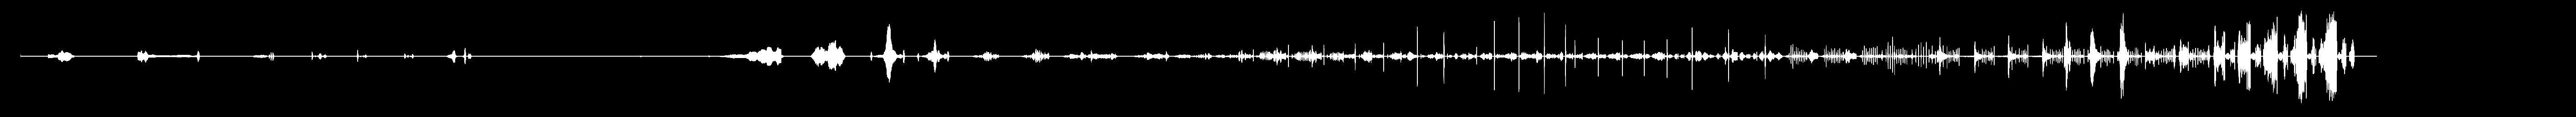

In [11]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(100,4))
plt.plot(all_vocalizations[snippet], color='white')
ax.axis('off')

In [12]:
IPython.display.Audio(data=all_vocalizations[snippet], rate=44100)

### Generate Spectrograms and vocal envelope

In [13]:
### Mel Compression
mel_filter, mel_inversion_filter = create_mel_filter(fft_size = param_dict['fft_size'],
                                                        n_freq_components = param_dict['n_mel_freq_components'],
                                                        start_freq = param_dict['start_freq'],
                                                        end_freq = param_dict['end_freq'])

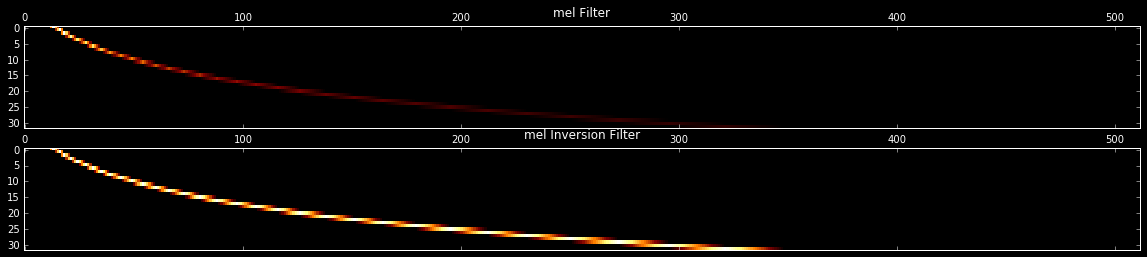

In [14]:
# take a look at both of the filters
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,4))
ax[0].matshow(np.transpose(mel_filter),cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[0].set_title('mel Filter')
ax[1].matshow(mel_inversion_filter,cmap=plt.cm.afmhot, interpolation='nearest', aspect='auto')
ax[1].set_title('mel Inversion Filter')

In [15]:
def create_audio_envelope_waveform(waveform,wav_spectrogram, downsampled_rate,
                                   rate = 44100,gauss_sigma_s=0.0,
                                   smoothing = 'gaussian', signal='spectrogram'
                                  ):
    """ Creates an audio envelope from waveform"""
    if signal == 'waveform':
        downsampled = scipy.signal.resample(np.abs(waveform),
                                          int(float(len(waveform))/rate*downsampled_rate))    
    elif signal == 'spectrogram':
        downsampled = np.max(wav_spectrogram, axis = 1)
    if smoothing == 'gaussian':
        gauss_sigma_f = downsampled_rate*gauss_sigma_s
        return norm(scipy.ndimage.filters.gaussian_filter(np.array(downsampled, np.float32), gauss_sigma_f))
    elif smoothing == 'none':
        return norm(downsampled)

def contiguous_regions(condition):
    # Compute contiguous region of silence to ensure noise levels are sufficiently low
    idx = []
    i = 0
    while i < len(condition):
        x1 = i + condition[i:].argmax()
        try:
            x2 = x1 + condition[x1:].argmin()
        except:
            x2 = x1 + 1
        if x1 == x2:
            if condition[x1] == True:
                x2 = len(condition)
            else:
                break
        idx.append( [x1,x2] )
        i = x2
    return idx
    
def temporal_segmentation_int(vocal_envelope,fft_rate, segmentation_rate = 1., threshold_max = .3):
    """ Adds dynamic threshold to vocal envelope
    """
    last_seg = 0
    seg_thresh = np.zeros((len(vocal_envelope)))
    for i in np.arange(1, len(vocal_envelope)):
        if vocal_envelope[i] > seg_thresh[i-1]:
            seg_thresh[i] = seg_thresh[i-1] + (segmentation_rate/fft_rate)
        else:
            vocal_envelope[i] = 0
        if seg_thresh[i] > threshold_max:
            seg_thresh[i] = threshold_max
            
    return vocal_envelope, seg_thresh

def generate_fft_time_idx(tix, voc, mel_spec):
    # generate time index for wav
    start_time = tix[0]
    stop_time = tix[-1]
    fft_time_idx = np.arange(start_time,stop_time,float(stop_time - start_time)/np.shape(mel_spec)[0])
    fft_time_idx = fft_time_idx[1:-1]
    fft_rate = 1. / (len(voc)/float(rate) / float(np.shape(mel_spec)[0]) )      
    return fft_time_idx, fft_rate


def compute_spec_and_env(vocalization,time_index, params):
    """
    """
    exec ','.join(params) + ', = params.values()'
    vocalization = vocalization.astype('float64')/np.max(vocalization)

    # Loop to make sure there are contigouous regions of silence in the song, 
    #  which is an indicator that background noise is being sufficiently thresholded
    envelope_is_good = False 
    cur_spec_thresh = spec_thresh
    #cur_spec_thresh = 3.5
    
    
    freq_step_size = ((rate/2)/(n_mel_freq_components))
    while envelope_is_good == False:
        
        if cur_spec_thresh < spec_thresh_min:
            return 0,0,0,0,0,0,0,0
        
        wav_spectrogram = pretty_spectrogram(vocalization, fft_size = fft_size, 
                               step_size = step_size, log = True, thresh = cur_spec_thresh)

        # Convert spectrogram to mel scale
        mel_spec = make_mel(wav_spectrogram, mel_filter)
        mel_spec = norm_zero_one(mel_spec)
        
        # Grab timing into
        #if timing_computed == False:
        fft_time_idx, fft_rate = generate_fft_time_idx(time_index, vocalization, mel_spec.T)

        # Which type of vocal envelope should we use?
        vocal_envelope = create_audio_envelope_waveform(np.abs(vocalization),
                                                        wav_spectrogram = mel_spec.T, downsampled_rate = fft_rate,
                                           rate = rate,gauss_sigma_s=gauss_sigma_s,
                                           smoothing = smoothing, signal=envelope_signal
                                          )
        vocal_envelope = np.concatenate((vocal_envelope, np.zeros(1000)))[:np.shape(mel_spec)[1]]
        
        ### TEST
        surr_envelope = create_audio_envelope_waveform(np.abs(vocalization),wav_spectrogram = mel_spec[FOI_min:FOI_max,:].T, downsampled_rate = fft_rate,
                                           rate = rate,gauss_sigma_s=gauss_sigma_s*3,
                                           smoothing = smoothing, signal=envelope_signal
                                          )
        surr_envelope = np.concatenate((surr_envelope, np.zeros(1000)))[:np.shape(mel_spec)[1]]

        cur_spec_thresh -= spec_thresh_delta

        # Look at how much silence exists in the signal
        cr = np.array(contiguous_regions(vocal_envelope == 0))
        
        if len(cr) == 0:
            continue
        
        if np.max(cr[:, 1] - cr[:, 0]) > fft_rate*.5: # needs .5 seconds of silence 
            envelope_is_good = True
    
    mel_spec = np.floor(norm_zero_one(mel_spec)* 255.).astype('uint8')
    mel_spec_orig = copy.deepcopy(mel_spec)
    mel_spec[mel_spec < (mel_noise_filt*np.max(mel_spec))] = 0
        
    #vocal_envelope = norm(np.max(mel_spec[FOI_min:FOI_max, :], axis =0))
    
    vocal_envelope = create_audio_envelope_waveform(np.abs(vocalization),
                                                        wav_spectrogram = mel_spec[FOI_min:FOI_max, :].T, downsampled_rate = fft_rate,
                                           rate = rate,gauss_sigma_s=gauss_sigma_s,
                                           smoothing = smoothing, signal=envelope_signal
                                          )
    vocal_envelope = np.concatenate((vocal_envelope, np.zeros(1000)))[:np.shape(mel_spec)[1]]
    
    """fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(100,6))
    cax = ax[0].matshow(spectrogram.T, interpolation=None, aspect='auto', origin='lower')# cmap=plt.cm.afmhot
    ax[1].plot(vocal_envelope, color = 'white', lw=2)
    #ax[1].plot(seg_thresh* np.shape(spectrogram)[0], color = 'white')
    ax[0].set_xlim([0, len(vocal_envelope)])
    ax[1].set_xlim([0, len(vocal_envelope)])
    plt.show()"""
    
    #Dynamically shift segmentation threshold
    vocal_envelope, seg_thresh = temporal_segmentation_int(vocal_envelope, fft_rate, segmentation_rate = segmentation_rate, threshold_max = threshold_max)
    
    return wav_spectrogram, mel_spec, vocal_envelope, seg_thresh, cur_spec_thresh, mel_spec_orig, fft_time_idx, fft_rate

In [16]:
wav_spectrogram, mel_spec, vocal_envelope, seg_thresh, cur_spec_thresh, mel_spec_orig, fft_time_idx, fft_rate = compute_spec_and_env(all_vocalizations[snippet],
                                                                                                                                         time_index[snippet], param_dict)

In [17]:
print cur_spec_thresh

3.6


In [1]:
start_time = fft_time_idx[0]
stop_time = fft_time_idx[-1]
fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(100,16))
ax[0].matshow(wav_spectrogram.T, interpolation=None, aspect='auto', # cmap=plt.cm.gray_r,
                 cmap=plt.cm.afmhot, origin='lower', extent=[start_time,stop_time,0,rate/2])
ax[0].set_title('Original Spectrogram')

ax[1].matshow(np.array(mel_spec_orig*255., dtype='int32'), interpolation=None, aspect='auto', cmap=plt.cm.jet, origin='lower',
                 extent=[start_time,stop_time,0,rate/2])
#fig.colorbar(cax)
ax[1].set_title('Mel Spectrogram')

ax[2].plot(vocal_envelope, color = 'white')
ax[2].plot(seg_thresh, color = 'blue')
ax[2].set_xlim([0,len(vocal_envelope)])
ax[2].set_title('Vocal Envelope')


NameError: name 'fft_time_idx' is not defined

In [2]:
# Output some stats of our file
print ''.join(['mel Spectrogram Size: ',str(np.shape(mel_spec))])
print ''.join(['Original Spectrogram Size: ',str(np.shape(np.transpose(wav_spectrogram)))])
print ''.join(['Original Waveform Size: ',str(np.shape(all_vocalizations[snippet]))])
print ''.join(['Length (s): ', str(len(all_vocalizations[snippet])/float(rate))])
print ''.join(['Original Sampling Rate (ms) : ', str(1./float(rate))])
print ''.join(['New Sampling Rate (ms): ', str(round((len(all_vocalizations[snippet])/float(rate))*1000 / float(np.shape(mel_spec)[1]), 3))])

NameError: name 'np' is not defined

### Syllabification: detect onsets and offsets of noise/vocalization

In [20]:
def detect_onsets_offsets(data, threshold, min_distance):
    """
    detects when a when a signal jumps above zero, and when it goes back to zero
    """
    on = (data>threshold) # when the data is greater than zero
    left_on = np.concatenate(([0], on), axis = 0)[0:-1]
    onset = np.squeeze(np.where(on & (left_on != True)))
    offset = np.squeeze(np.where((on != True) & (left_on == True)))
    
    if data[-1] > threshold:
        offset = np.append(offset,len(data)) # make sure there is an offset at some point...

    if len(np.shape(onset)) < 1:
        offset = [offset]
        onset = [onset]

    new_offset = []
    new_onset = []
    if len(onset) > 0:
        new_onset.append(onset[0])
        if len(onset) > 1:
            for i in range(len(onset)-1):
                if (onset[i+1] - offset[i]) > min_distance:
                    new_onset.append(onset[i+1])
                    new_offset.append(offset[i])

        new_offset.append(offset[-1])
    return new_onset, new_offset 

In [21]:
# Detect onsets and offsets of vocal envelope
onsets, offsets = detect_onsets_offsets(vocal_envelope, 
      threshold = param_dict['silence_threshold'],
      min_distance = 0.
     )

print onsets[0:10], offsets[0:10], len(onsets)

[496, 2145, 3298, 4257, 4568, 4635, 5356, 5403, 5467, 5557] [982, 3297, 3299, 4542, 4630, 4666, 5391, 5442, 5549, 5637] 122


### Syllabification

In [22]:
def plot_seg_spec(all_seg_points, spectrogram,mel_spec, fft_time_idx, vocal_envelope_int, seg_thresh, params):
    """ Draw plot of segmentation
    """
    exec ','.join(params) + ', = params.values()'

    fig, ax = plt.subplots(nrows=3,ncols=1, figsize=(100,9))
    cax = ax[0].matshow(spectrogram, interpolation=None, aspect='auto', origin='lower')# cmap=plt.cm.afmhot
    for i in all_seg_points:
        ax[0].axvline(i, color='w', linestyle='-', lw=3,  alpha = .75)#, ymax=.25)
    cax = ax[1].matshow(mel_spec, interpolation=None, aspect='auto', origin='lower')# cmap=plt.cm.afmhot
    ax[1].axhline(y=FOI_min, color = 'w')
    ax[1].axhline(y=FOI_max, color = 'w')
    ax[0].set_xlim([0, len(vocal_envelope_int)])
    ax[1].set_xlim([0, len(vocal_envelope_int)])
    #ax[2].plot(np.argmax(mel_spec_orig, axis=0), color = 'green')
    ax[2].plot(vocal_envelope_int* np.shape(mel_spec)[0], color = 'white')
    ax[2].plot(seg_thresh* np.shape(mel_spec)[0], color = 'blue')
    #ax[2].plot(np.sum(mel_spec, axis=0))
    ax[2].set_xlim([0, len(vocal_envelope_int)])
    
    ax[2].plot(norm(np.max(mel_spec[FOI_min:FOI_max, :], axis =0))*np.shape(mel_spec)[0], color = 'red')


    plt.show()

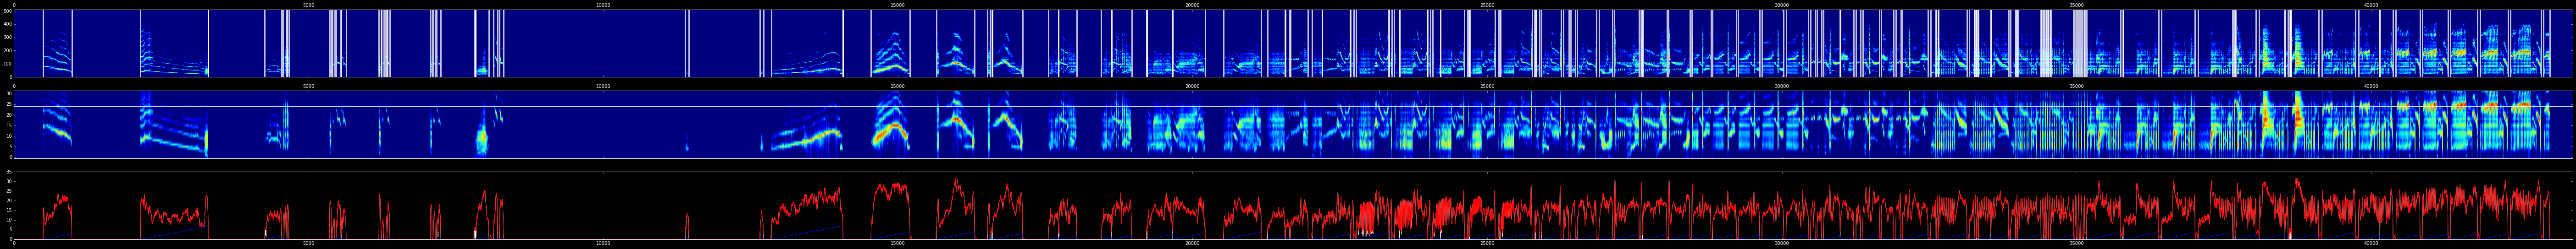

In [23]:
plot_seg_spec(np.concatenate(np.array((onsets,offsets))), wav_spectrogram.T, mel_spec_orig, fft_time_idx, vocal_envelope, seg_thresh, param_dict)  

In [24]:
def cut_syllables(onsets, offsets, mel_spec, fft_time_idx, params):
    exec ','.join(params) + ', = params.values()'
    # Cut into syllables 
    all_syllables = []
    all_syllables_time_idx = []
    
    for i,on in enumerate(onsets):
        if offsets[i]> on+min_len: # if the syllable is sufficiently long
            cur_seg_points = np.concatenate((
                [np.squeeze(onsets[i])],[np.squeeze(offsets[i])]))
            for j in range(len(cur_seg_points)-1):
                all_syllables.append(mel_spec[:,cur_seg_points[j]:cur_seg_points[j+1]]) 
                all_syllables_time_idx.append(fft_time_idx[cur_seg_points[j]:cur_seg_points[j+1]])
               
    
    syll_start = [i[0] for i in all_syllables_time_idx] # Syllable start times, seconds
    return all_syllables, all_syllables_time_idx, syll_start

# segment into syllables based upon onset/offsets
all_syllables, all_syllables_time_idx, syll_start = cut_syllables(onsets, offsets, mel_spec_orig, fft_time_idx, param_dict)
# Timing for when each syllable started (seconds)
print syll_start[0:5]

[0.7215659789164004, 3.1156551121822842, 6.1819475618230033, 6.633470739776727, 6.7307442218439277]


### Thresholding out bad syllables

In [25]:
# threshold/remove bad syllables
def threshold_syllables(all_syllables, all_syllables_time_idx, syll_start, min_syll_len_s, power_thresh = .3, visual = False, max_vis = 20):
    """ Threshold syllables based on length 
    """
    # Threshold time
    good_sylls = np.array([np.shape(i)[1] for i in all_syllables])/float(fft_rate)>=min_syll_len_s
    
    all_syllables= [all_syllables[i] for i, b in enumerate(good_sylls) if b == True]
    all_syllables_time_idx = np.array(all_syllables_time_idx)[good_sylls]
    syll_start = np.array(syll_start)[good_sylls]
    
    good_sylls = np.array([np.max(i) for i in all_syllables])>=power_thresh
    
    if visual == True:
        # Threshold low power
        fig, ax = plt.subplots(nrows=3,ncols=max_vis, figsize=(2*max_vis,6))
        for syll_i, syll in enumerate(all_syllables):
            if good_sylls[syll_i] == True:
                cm = plt.cm.afmhot
            else:
                cm = plt.cm.bone
            ax[0,syll_i].matshow(syll, 
                                cmap=cm,
                                origin='lower',
                                aspect='auto',
                                interpolation='nearest',
                                vmin=0, vmax=1
                               )
            ax[1,syll_i].plot(np.sum(syll, axis = 0))
            ax[2,syll_i].plot(np.sum(syll, axis = 1))
            if syll_i >= max_vis-1:
                break
            
        plt.show()
    
    all_syllables= [all_syllables[i] for i, b in enumerate(good_sylls) if b == True]
    all_syllables_time_idx = np.array(all_syllables_time_idx)[good_sylls]
    syll_start = np.array(syll_start)[good_sylls]
    
    return all_syllables, all_syllables_time_idx, syll_start

0.00871105809557 1.76108557832 0.343348774575
[0.7055957057411884, 1.6725231543494834, 0.4137752595395857, 0.090014266987559, 0.0450071334937795]


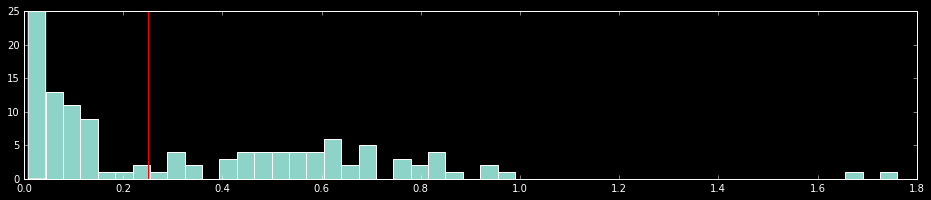

In [26]:
syllable_lengths = [np.shape(all_syllables[i])[1]/fft_rate for i in range(len(all_syllables))]
print np.min(syllable_lengths), np.max(syllable_lengths), np.mean(syllable_lengths)
print syllable_lengths[0:5]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,3))
_ = plt.hist(syllable_lengths,bins=50)
ax.axvline(x=param_dict['min_syll_len_s'], color = 'red')

In [27]:
all_syllables, all_syllables_time_idx, syll_start = threshold_syllables(all_syllables, all_syllables_time_idx, syll_start, param_dict['min_syll_len_s'])

[0.7055957057411884, 1.6725231543494834, 0.4137752595395857, 0.3237609925520267, 1.7610855783211141]


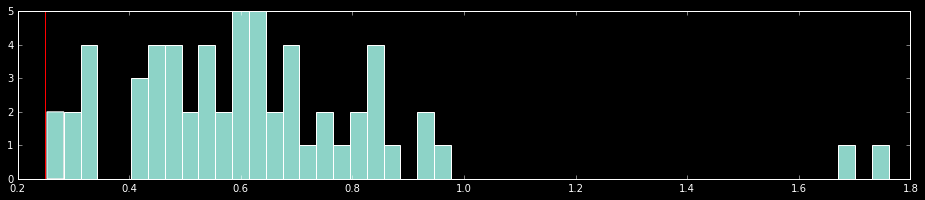

In [28]:
syllable_lengths = [np.shape(all_syllables[i])[1]/fft_rate for i in range(len(all_syllables))]
print syllable_lengths[0:5]

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(16,3))
_ = plt.hist(syllable_lengths,bins=50)
ax.axvline(x=param_dict['min_syll_len_s'], color = 'red')

### Resize and Pad Spectrograms

In [29]:
def pad_spectrogram(spectrogram, pad_length):
    excess_needed = (pad_length - np.shape(spectrogram)[1])
    pad_left = np.floor(float(excess_needed)/2).astype('int')
    pad_right = np.ceil(float(excess_needed)/2).astype('int')
    return np.pad(spectrogram, [(0,0), (pad_left,pad_right)], 'constant', constant_values = 0)

In [30]:
def resize_spectrograms(all_syllables, max_size, resize_samp_fr, fft_rate):
    """ Resizes and pads a list of spectrograms
    """
    for i, syll in enumerate(all_syllables):
        # 
        if (np.shape(syll)[1]/fft_rate)*resize_samp_fr > max_size:
            samp_fr_cur = (np.float(max_size)/np.shape(syll)[1] ) * fft_rate
        else:
            samp_fr_cur = resize_samp_fr
        
        all_syllables[i] = scipy.ndimage.zoom(syll.astype('float32'), 
                                              [1, samp_fr_cur/fft_rate])
        
    return all_syllables

In [31]:
all_syllables = resize_spectrograms(all_syllables, max_size = 32, resize_samp_fr = 32, fft_rate = fft_rate)
all_syllables = [pad_spectrogram(i, param_dict['pad_length']) for i in all_syllables]

/home/AD/tsainbur/.conda/envs/tim_tf/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


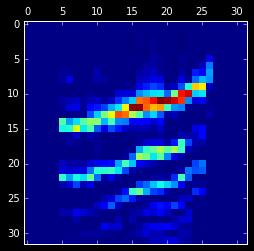

In [32]:
plt.matshow(all_syllables[0])

In [33]:
all_syllables = [np.floor(norm(i)*255.).astype('uint8') for i in all_syllables]

### Plot computed syllables

In [34]:
def plt_all_syllables(all_syllables, n_mel_freq_components, max_rows = 3, max_sylls = 100, width = 400):
    
    
    
    canvas = np.zeros(( n_mel_freq_components*max_rows, width), dtype='uint8')
    x_loc = 0
    row = 0
    for i, syll in enumerate(all_syllables):  
        
        # if the syllable is too long
        if np.shape(syll)[1] > width:
            continue
        
        if (x_loc+np.shape(syll)[1]) > width:
            if row == max_rows-1:
                break
                
            else:
                row +=1
                x_loc = 0
        canvas[row*n_mel_freq_components: (row+1)*n_mel_freq_components, x_loc:(x_loc+np.shape(syll)[1])] = np.flipud(syll)
        x_loc += np.shape(syll)[1]
    
    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(width/32, max_rows))
    ax.matshow(canvas, 
                cmap=plt.cm.afmhot,
                #origin='lower',
                aspect='auto',
                interpolation='nearest',
                vmin=0, vmax=255
               )
    plt.show()

    

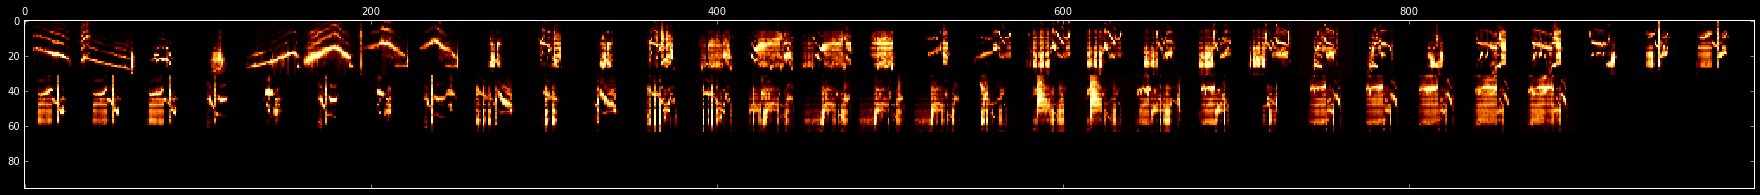

In [35]:
plt_all_syllables(all_syllables, param_dict['n_mel_freq_components'],  max_rows = 3, max_sylls = 100, width = 1000)

### Gather bird folders

In [36]:
search_directory = '../data/HDF5_of_threshed_wavs/old/*.npz'
bird_folders = glob(search_directory)
bird_folders.sort()
#bird_folders = bird_folders[::-1]
print bird_folders[0:3]

['../data/HDF5_of_threshed_wavs/old/B165_OSL.npz', '../data/HDF5_of_threshed_wavs/old/B211_OSL.npz', '../data/HDF5_of_threshed_wavs/old/B335_OSL.npz']


In [37]:
dt = h5py.special_dtype(vlen=str)
def save_dataset(location, all_bird_syll, starting_times,lengths,wav_file,syll_start_rel_to_wav, bird_name):
    with h5py.File(location, 'w') as f:
        f.attrs['bird_name'] = bird_name
        dset_spec = f.create_dataset("spectrograms", np.shape(all_bird_syll), dtype='uint8', data = all_bird_syll)        
        dset_start = f.create_dataset("start", (len(starting_times),1), dtype=dt, data = starting_times)
        dset_wav_file = f.create_dataset("wav_file", (len(wav_file),1), dtype=dt, data = wav_file)
        dset_syll_start_rel_to_wav = f.create_dataset("syll_start_rel_wav", 
                              np.shape(syll_start_rel_to_wav), dtype='float32', data = syll_start_rel_to_wav)
        dset_lengths = f.create_dataset("lengths", np.shape(lengths), dtype='float32', data = lengths)

### Processing data

In [38]:
def process_bout(vocalization,time_index, params, wav_file,wav_time,  visualize=False):
    """ Processes a single bout for syllable information
    """
    exec ','.join(params) + ', = params.values()'
    
    # bandpass filter data
    vocalization = butter_bandpass_filter(vocalization, lowcut, highcut, rate, order=2)
    
    # Compute spectrogram
    wav_spectrogram, mel_spec, vocal_envelope, seg_thresh, cur_spec_thresh, mel_spec_orig, fft_time_idx, fft_rate = compute_spec_and_env(vocalization,time_index, params)
    
    # Return nothing if spectrogram function outputs nothing
    if np.shape(wav_spectrogram) == ():
        return [], [], [], [], [] 
    
    
     # Detect onsets and offsets of vocal envelope
    onsets, offsets = detect_onsets_offsets(vocal_envelope, 
              threshold = silence_threshold,
              min_distance = 0.
             )

    # if the wav is empty continue (unlikely) 
    if len(onsets) == 0:
        return [], [], [], [], []     
    
    # segment into syllables based upon onset/offsets
    all_syllables, all_syllables_time_idx, syll_start = cut_syllables(onsets, offsets, mel_spec_orig, fft_time_idx, params)
    # threshold/remove bad syllables
    all_syllables, all_syllables_time_idx, syll_start = threshold_syllables(all_syllables, all_syllables_time_idx, syll_start, min_syll_len_s)
    

    
    # Threshold for too few syllables
    if len(all_syllables) < min_num_sylls:
        return [], [], [], [], []     
    
    # get syllable timing information
    syll_start_dt = [dati.strftime("%d/%m/%y %H:%M:%S.%f") for dati in [wav_time  + timedelta(seconds=st) for st in syll_start]] # datetime info for when the syllable occurs
    syllable_lengths = [np.shape(all_syllables[i])[1]/fft_rate for i in range(len(all_syllables))] # length of each syllable
    # resize syllables
    all_syllables = resize_spectrograms(all_syllables, max_size = 32, resize_samp_fr = 32, fft_rate = fft_rate)
    # pad syllables
    all_syllables = [pad_spectrogram(i, pad_length) for i in all_syllables]
    all_syllables = [np.floor(norm(i)*255.).astype('uint8') for i in all_syllables] # normalize syllables
    if visualize == True:
        print 'spec thresh: ', cur_spec_thresh, 'spec mean: ', np.mean(mel_spec)     
        plot_seg_spec(np.concatenate(np.array((onsets,offsets))), wav_spectrogram.T, mel_spec, fft_time_idx,vocal_envelope, seg_thresh, params)  
        plt_all_syllables(all_syllables,n_mel_freq_components,  max_rows = 3, max_sylls = 100, width = 1000)
        print wav_file
        process = psutil.Process(os.getpid())
        print('Memory usage', process.memory_info().rss)

    # add to the wav 
    wf = np.array([wav_file for i in range(len(all_syllables))])
    
    return wf, all_syllables, syll_start_dt, syll_start, syllable_lengths  
    

#### Test with visualizations

In [39]:
bird_df = pd.DataFrame((all_vocalizations), columns = ['all_vocalization'])                            
bird_df['time_idx'] = list(time_index)
bird_df['wav_file'] = wav_file
bird_df['wav_time'] = wav_time
bird_df[0:3]

all_vocalization              time_idx  \
0  [-288.204, -1159.93, -1628.37, -851.323, -151....  [0.0, 78.5496371882]   
1  [175.545, 707.109, 994.432, 522.827, 94.8874, ...  [0.0, 74.5193424036]   
2  [-276.078, -1109.14, -1549.33, -789.037, -103....  [0.0, 66.9178004535]   

                                            wav_file            wav_time  
0  /mnt/lintu/home/Gentnerlab/share/stimuli/OneSt... 1900-01-29 15:00:00  
1  /mnt/lintu/home/Gentnerlab/share/stimuli/OneSt... 1900-01-29 17:00:00  
2  /mnt/lintu/home/Gentnerlab/share/stimuli/OneSt... 1900-01-29 18:00:00

### Non parallel (For visualization and bug fixing)

In [40]:
key_list = ('all_bird_wav_file', 'all_bird_syll', 'all_bird_syll_start', 'all_bird_t_rel_to_file', 'all_bird_syll_lengths') 
for bird_folder in bird_folders:
    bird_name = bird_folder.split('/')[-1][:-4]

    if bird_name != 'B211_OSL':
        continue
    print bird_name

    # initialize lists of bird information
    bird_data = {key : [] for key in key_list}
    
    print('Loading file... ', bird_folder)
    # Load bird wavs
    time_index, all_vocalizations, all_rate, wav_file, wav_time = load_npz(bird_folder)

    #print('Creating reference dataset... ') 
    # CREATE AN INPUT DF
    #bird_df = pd.DataFrame((all_vocalizations), columns = ['all_vocalization'])                            
    #bird_df['time_idx'] = list(time_index)
    #bird_df['wav_file'] = wav_file
    #bird_df['wav_time'] = wav_time
    #bird_df = bird_df[0:3]
    
    print 'Number of bouts:' , len(bird_df)

    #bird_data_packed = [process_bout(voc,t_idx,param_dict, wf, wt, visualize = True) for ix, voc, t_idx, wf, wt in tqdm(bird_df.itertuples())]
    bird_data_packed = [process_bout(voc,t_idx,param_dict, wf, wt, visualize = True) for voc, t_idx, wf, wt in tqdm(zip(all_vocalizations,
                                                                                                                        time_index,
                                                                                                                        wav_file,
                                                                                                                        wav_time
                                                                                                                       ))]
                        


    for dtype, darray in zip(key_list, zip(*bird_data_packed)):
            [bird_data[dtype].extend(element) for element in darray] # flatten and clear darray -> bird_data[dtype]
            bird_data[dtype] = np.array(bird_data[dtype])

    # reformat bird syllables
    print 'len dataset: ', len(np.array(list(itertools.chain.from_iterable(all_bird_syll_lengths))))
    


"key_list = ('all_bird_wav_file', 'all_bird_syll', 'all_bird_syll_start', 'all_bird_t_rel_to_file', 'all_bird_syll_lengths') \nfor bird_folder in bird_folders:\n    bird_name = bird_folder.split('/')[-1][:-4]\n\n    if bird_name != 'B211_OSL':\n        continue\n    print bird_name\n\n    # initialize lists of bird information\n    bird_data = {key : [] for key in key_list}\n    \n    print('Loading file... ', bird_folder)\n    # Load bird wavs\n    time_index, all_vocalizations, all_rate, wav_file, wav_time = load_npz(bird_folder)\n\n    #print('Creating reference dataset... ') \n    # CREATE AN INPUT DF\n    #bird_df = pd.DataFrame((all_vocalizations), columns = ['all_vocalization'])                            \n    #bird_df['time_idx'] = list(time_index)\n    #bird_df['wav_file'] = wav_file\n    #bird_df['wav_time'] = wav_time\n    #bird_df = bird_df[0:3]\n    \n    print 'Number of bouts:' , len(bird_df)\n\n    #bird_data_packed = [process_bout(voc,t_idx,param_dict, wf, wt, visuali

#### Run through in parallel

In [41]:
skip_existing = True

In [43]:
key_list = ('all_bird_wav_file', 'all_bird_syll', 'all_bird_syll_start', 'all_bird_t_rel_to_file', 'all_bird_syll_lengths') 
with Parallel(n_jobs=5, verbose=5) as parallel:
    for bird_folder in bird_folders:
        bird_name = bird_folder.split('/')[-1][:-4]
        
        filename = ''.join(['../data/HDF5_of_syllable_specs/',bird_name,'.hdf5'])
        
        if os.path.exists(filename) and skip_existing:
            print '%s already complete, skipping' % (bird_name)
        else:

            #if bird_name != 'b1074_Zeke':
            #    continue

            print bird_name

            # initialize lists of bird information
            bird_data = {key : [] for key in key_list}

            # Load bird wavs
            time_index, all_vocalizations, all_rate, wav_file, wav_time = load_npz(bird_folder)

            bird_data_packed = parallel(
                delayed(process_bout)(voc,t_idx,param_dict, wf, wt, visualize = False) 
                     for voc, t_idx, wf, wt in tqdm(zip(all_vocalizations,time_index, wav_file, wav_time)))


            for dtype, darray in zip(key_list, zip(*bird_data_packed)):
                    [bird_data[dtype].extend(element) for element in darray] # flatten and clear darray -> bird_data[dtype]
                    bird_data[dtype] = np.array(bird_data[dtype])

            # reformat bird syllables
            print 'len dataset: ', len(bird_data['all_bird_syll_lengths'])

            #break
            # Save syllables to a dataset
            #break
            save_dataset(filename, 
                         bird_data['all_bird_syll'], 
                         bird_data['all_bird_syll_start'],
                         bird_data['all_bird_syll_lengths'], 
                         bird_data['all_bird_wav_file'],
                         bird_data['all_bird_t_rel_to_file'],
                         bird_name
                        )

B165_OSL already complete, skipping
B211_OSL already complete, skipping
B335_OSL already complete, skipping
B336_OSL already complete, skipping
B337_OSL already complete, skipping
B338_OSL already complete, skipping
b1074_Zeke already complete, skipping
b1080_Zeke already complete, skipping
b1094_Zeke already complete, skipping
b1114_Zeke already complete, skipping
b1114_zPhys


100%|██████████| 249/249 [18:58<00:00,  3.64s/it]
[Parallel(n_jobs=5)]: Done 249 out of 249 | elapsed: 20.1min finished


len dataset:  100
b1174_Zeke


100%|██████████| 35/35 [02:12<00:00,  4.48s/it]
[Parallel(n_jobs=5)]: Done  35 out of  35 | elapsed:  3.2min finished


len dataset:  385


In [ ]:
process = psutil.Process(os.getpid())
print('Memory usage', process.memory_info().rss)

In [ ]:
print 'test'